## Model assesment

This notebook is used for perliminary assesment of the performance of the RoBERTa.

Specificly it looks as:
* Can we interpet anything from the attentionweights using bertvis
* Is it easy to fool?
* * If we ask for effective period and just drop random dates into different context what sort of results do we get


### Obtaining model results

This sections gathers the predictions of the model

In [3]:
import torch
import time
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

from transformers import (
    AutoConfig,
    AutoModelForQuestionAnswering,
    AutoTokenizer,
    squad_convert_examples_to_features
)

from transformers.data.processors.squad import SquadResult, SquadV2Processor, SquadExample
from transformers.data.metrics.squad_metrics import compute_predictions_logits
from datasets import load_dataset

This section should be renconfigured to have the correct format for the model being tested

In [4]:
model_path='Rakib/roberta-base-on-cuad'
model_name="huggingface_cuad"
config = AutoConfig.from_pretrained(
        model_path,
        cache_dir=None,
    )
tokenizer = AutoTokenizer.from_pretrained(
    model_path,
    do_lower_case=True,
    use_fast=False,  # SquadDataset is not compatible with Fast tokenizers which have a smarter overflow handeling
)
model = AutoModelForQuestionAnswering.from_pretrained(
    model_path,
    from_tf=bool(".ckpt" in model_path),
    config=config,
    cache_dir=None,
)
model_type="roberta_cuad"

Obtaining the dev examples - slow running

In [4]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "true"

In [5]:
doc_stride=128
max_query_length=64
max_seq_length=512
evaluate=True
threads=4

from os import path

if not path.exists(f'./{model_name}_data_examples'):
    processor = SquadV2Processor()
    examples = processor.get_dev_examples('./', filename='./test.json')
    
    features, dataset = squad_convert_examples_to_features(
    examples=examples,
    tokenizer=tokenizer,
    max_seq_length=max_seq_length,
    doc_stride=doc_stride,
    max_query_length=max_query_length,
    is_training=not evaluate,
    return_dataset="pt",
    threads=threads,
    )
    torch.save({"features": features, "dataset": dataset, "examples": examples}, f'./{model_name}_data_examples')


Prep data for processing

In [22]:
data =torch.load(f'./{model_name}_data_examples')

In [23]:
# If you already have the data
features, dataset, examples = data.values()
batch_size=32
eval_sampler = SequentialSampler(dataset)
eval_dataloader = DataLoader(dataset, sampler=eval_sampler, batch_size=batch_size)

In [24]:
def to_list(tensor):
    return tensor.detach().cpu().tolist()

In [25]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

model.to(device)
print()

Using device: cuda

Tesla T4
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB



Running the inference. Remember to convert it into the correct format for your model

In [ ]:
from tqdm import tqdm
all_results = []

for batch in tqdm(eval_dataloader, desc="Evaluating"):
    model.eval()
    batch = tuple(t.to(device) for t in batch)

    with torch.no_grad():
        inputs = {
            "input_ids": batch[0],
            "attention_mask": batch[1],
            "token_type_ids": batch[2],
        }

        if model_type in ["xlm", "roberta", "distilbert", "camembert", "bart", "longformer"]:
            del inputs["token_type_ids"]

        feature_indices = batch[3]

        outputs = model(**inputs)

    for i, feature_index in enumerate(feature_indices):
        eval_feature = features[feature_index.item()]
        unique_id = int(eval_feature.unique_id)

        output = [to_list(output[i]) for output in outputs.to_tuple()]

        # Some models (XLNet, XLM) use 5 arguments for their predictions, while the other "simpler"
        # models only use two.
        if len(output) >= 5:
            start_logits = output[0]
            start_top_index = output[1]
            end_logits = output[2]
            end_top_index = output[3]
            cls_logits = output[4]

            result = SquadResult(
                unique_id,
                start_logits,
                end_logits,
                start_top_index=start_top_index,
                end_top_index=end_top_index,
                cls_logits=cls_logits,
            )

        else:
            start_logits, end_logits = output
            result = SquadResult(unique_id, start_logits, end_logits)

        all_results.append(result)

Evaluating:  99%|█████████▉| 9414/9466 [2:59:15<00:59,  1.14s/it]  

In [ ]:
torch.save({"all_results":all_results}, f"all_results_{model_name}")

In [10]:
_all_res = torch.load(f"all_results_{model_name}")

In [11]:
all_results = _all_res['all_results']

In [12]:
import os
output_prediction_file = os.path.join("./", "predictions_{}.json".format(model_type))
output_nbest_file = os.path.join("./", "nbest_predictions_{}.json".format(model_type))
output_null_log_odds_file = os.path.join("./", "null_odds_{}.json".format(model_type))

from utils_cuad import compute_predictions_logits, squad_evaluate
import json
with open('test.json', "r") as f:
        json_test_dict = json.load(f)

In [13]:
n_best_size=1
max_answer_length=512
do_lower_case=True
verbose_logging=False
version_2_with_negative=True
null_score_diff_threshold=0.0

predictions = compute_predictions_logits(
    json_test_dict,
    examples,
    features,
    all_results,
    n_best_size,
    max_answer_length,
    do_lower_case,
    output_prediction_file,
    output_nbest_file,
    output_null_log_odds_file,
    verbose_logging,
    version_2_with_negative,
    null_score_diff_threshold,
    tokenizer,
)

# Compute the F1 and exact scores.
results = squad_evaluate(examples, predictions)

In [14]:
results

OrderedDict([('exact', 63.43854615016738),
             ('f1', 67.32509783602501),
             ('total', 4182),
             ('HasAns_exact', 66.07717041800643),
             ('HasAns_f1', 79.14273243589734),
             ('HasAns_total', 1244),
             ('NoAns_exact', 62.3213070115725),
             ('NoAns_f1', 62.3213070115725),
             ('NoAns_total', 2938),
             ('best_exact', 70.37302725968436),
             ('best_exact_thresh', 0.0),
             ('best_f1', 70.56444133343896),
             ('best_f1_thresh', 0.0)])

## Preparing the results for analysis

In [15]:
feat_dict = {}

In [16]:
for x in features:
    feat_dict[x.unique_id]=x

In [17]:
def decode(
    start: torch.tensor, end: torch.tensor, topk: int, max_answer_len: int
):
    """
    Take the output of any `ModelForQuestionAnswering` and will generate probabilities for each span to be the
    actual answer.
    In addition, it filters out some unwanted/impossible cases like answer len being greater than max_answer_len or
    answer end position being before the starting position. The method supports output the k-best answer through
    the topk argument.
    Args:
        start (`torch.tensor`): Individual start probabilities for each token.
        end (`torch.tensor`): Individual end probabilities for each token.
        topk (`int`): Indicates how many possible answer span(s) to extract from the model output.
        max_answer_len (`int`): Maximum size of the answer to extract from the model's output.
    """
    # Ensure we have batch axis
    if start.ndim == 1:
        start = start[None]

    if end.ndim == 1:
        end = end[None]

    # Compute the score of each tuple(start, end) to be the real answer
    outer = torch.matmul(start.unsqueeze(-1), end.unsqueeze(1))

    # Remove candidate with end < start and end - start > max_answer_len
    candidates = torch.tril(torch.triu(outer), max_answer_len - 1)
    #  Inspired by Chen & al. (https://github.com/facebookresearch/DrQA)
    scores_flat = candidates.flatten()
    # Get nr. 1
    if topk == 1:
        idx_sort = [torch.argmax(scores_flat)]
    elif len(scores_flat) < topk:
        idx_sort = torch.argsort(-scores_flat)
    else:
        idx = torch.topk(scores_flat, topk).indices
        idx_sort = idx[torch.argsort(-scores_flat[idx])]

    def unravel_index(index, shape):
        out = []
        for dim in reversed(shape):
            out.append(index % dim)
            index = torch.div(index, dim, rounding_mode='trunc')
        return tuple(reversed(out))
    starts, ends = unravel_index(idx_sort, candidates.shape)[1:]
    scores = candidates[:, starts, ends]

    return starts, ends, scores

In [22]:
_ans_ques

[]

In [25]:
from tqdm import tqdm
df_data =[]
m = torch.nn.Softmax(dim=-1)
for ele in tqdm(all_results):
    x,y,z = decode(m(torch.tensor(ele.start_logits)),m(torch.tensor(ele.end_logits)),3,max_answer_length)
    _pred = zip(x,y,z[0])
    feat=feat_dict.get(ele.unique_id)
    exampl = examples[feat.example_index]
    # Non changing
    ctx = tokenizer.decode(feat.input_ids[feat.p_mask.index(0,1):])
    q_feat_id = ele.unique_id
    example_index = feat.example_index
    
    _ans_ques = [x['text'] for x in exampl.answers]
    answer_in_span = False
    for ele in _ans_ques:
        if ele in ctx:
            answer_in_span=True        
    
    for idx, pred in enumerate(_pred):
        df_data.append(
            {'q_feat_id':q_feat_id,
             'example_index':example_index,
             'is_impossible':    feat.is_impossible,
             'answer_in_span':answer_in_span,
             'context':ctx,
             'qas_id':    feat.qas_id,
             'top_k':idx,
             'pred':tokenizer.decode(feat.input_ids[pred[0]:pred[1]+1]),
             'pred_conf':pred[2].cpu().item(),
             'ans':_ans_ques[-1] if _ans_ques else "<NO-ANS>",
             "multi_Ans": True if len(_ans_ques)>1 else False
            }
)

100%|██████████| 302899/302899 [20:58<00:00, 240.75it/s]


In [26]:
import os
import json
import pandas as pd
import numpy as np
from sklearn import metrics
def load_json(path):
    with open(path, "r") as f:
        dict = json.load(f)
    return dict
from utils_cuad import *
from evaluate_utils import *

In [137]:
df_test = pd.DataFrame(df_data)
pd.to_pickle(df_test, './df_test')

In [27]:
df_test = pd.read_pickle('./df_test')

Adding performance metrics

In [28]:
df_test['question_type']=df_test.apply(lambda x: x['qas_id'].split('__')[-1],axis=1)
df_test['text_pred_norm']=df_test.apply(lambda x: normalize_answer(x['pred']),axis=1)
df_test['text_ans_norm']=df_test.apply(lambda x: normalize_answer(x['ans']),axis=1)

In [29]:
df_test['em']=df_test.apply(lambda x: x['text_pred_norm']==x['text_ans_norm'], axis=1)
df_test['jaccard']=df_test.apply(lambda x: get_jaccard(x['text_ans_norm'], x['text_pred_norm']), axis=1)
df_test['jaccard_match']=df_test.apply(lambda x: get_jaccard(x['text_ans_norm'], x['text_pred_norm'])>=IOU_THRESH, axis=1)

Ranking the output to give top predictions for questions

In [30]:
df_test['rank']=df_test.groupby(by=['qas_id'])['pred_conf'].transform(lambda x: x.rank(ascending=False))
df_test['qas_id_int'] = df_test.qas_id.astype('category').cat.codes

In [31]:
print("Interesting qas_id_int's :",df_test[(df_test['is_impossible']==False)].qas_id_int.unique()[0:5])

Interesting qas_id_int's : [1977 1996 1980 1981 2008]


### Model results

Taking a look at how the model performs. Assumes the evaluation scripts has been run on the model

Performance on spans that include the answer. This is how the model is performing on the actual spans that include the answer and this should be representative of the performance. In general though we find the best predictions across the entire context. The rank should tell us something about that

In [33]:
df = df_test[df_test['answer_in_span']==True]

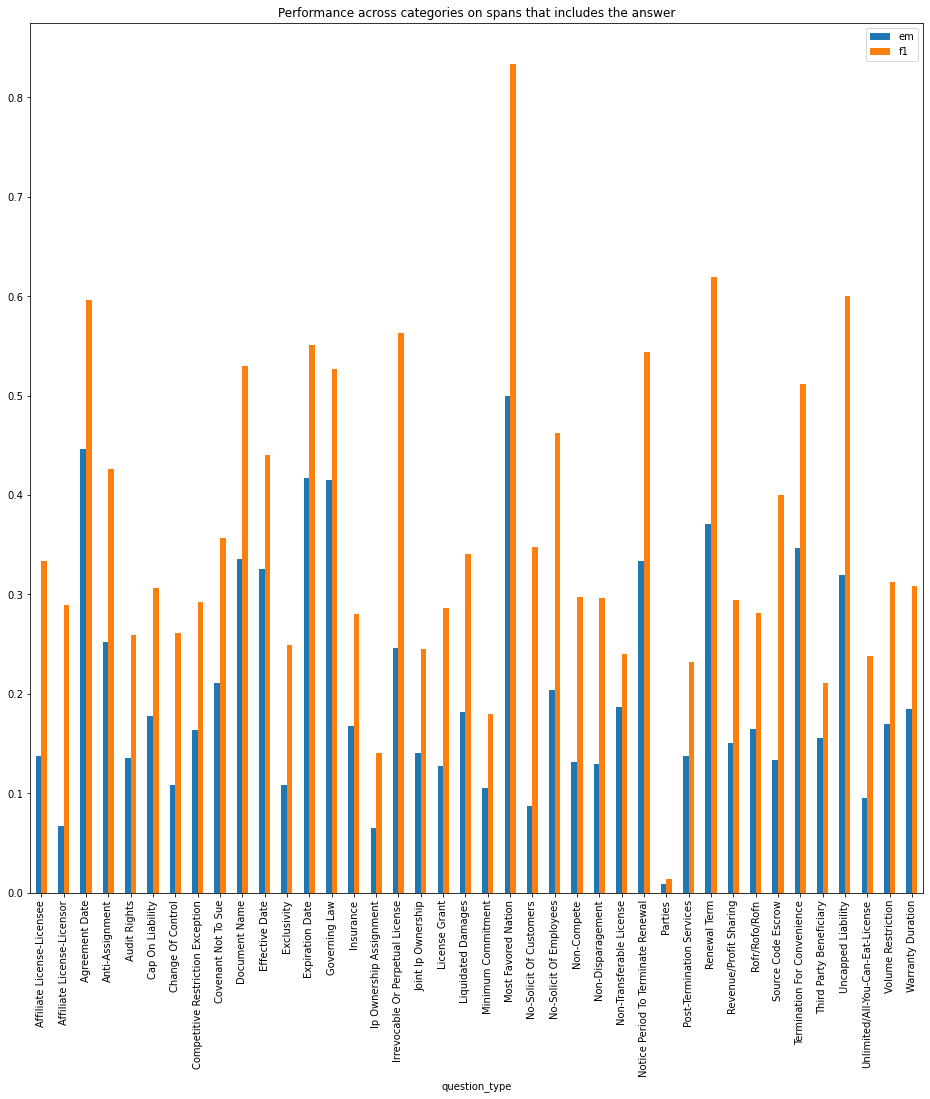

In [35]:
import matplotlib.pyplot as plt
agg = df.groupby('question_type').agg(['sum','count'])[['em','jaccard_match']]

df2=(agg['em']['sum']/agg['em']['count']).to_frame().merge((agg['jaccard_match']['sum']/agg['jaccard_match']['count']).to_frame(), left_index=True, right_index=True)

df2.rename(columns={'0_x':"em","0_y":"f1"}).plot(kind='bar', figsize=(16,16))
plt.title("Performance across categories on spans that includes the answer")

plt.show()

**Parties**

Performance on parties is encredably low. Actually this is the worst performing category... This is due to the multiple answers often being in the parties questions. Fix pending

In [113]:
df[(df['question_type']=='Parties') & (df['text_pred_norm']!="s")].head(5)

,q_feat_id,example_index,is_impossible,answer_in_span,context,qas_id,top_k,pred,pred_conf,ans,question_type,text_pred_norm,text_ans_norm,em,jaccard,jaccard_match,rank,qas_id_int
51,1000000017,1,False,True,Exhibit 10.16 SUPPLY CONTRACT Contract No: Da...,LohaCompanyltd_20191209_F-1_EX-10.16_11917878_...,0,SHENZHEN YICHANGTAI IMPORT AND EXPORT TRADE C...,0.104186,The buyer/End-User: Shenzhen LOHAS Supply Chai...,Parties,shenzhen yichangtai import and export trade co...,buyerenduser shenzhen lohas supply chain manag...,False,0.230769,False,18.0,1996
52,1000000017,1,False,True,Exhibit 10.16 SUPPLY CONTRACT Contract No: Da...,LohaCompanyltd_20191209_F-1_EX-10.16_11917878_...,1,SHENZHEN YICHANGTAI IMPORT AND EXPORT TRADE C...,0.075054,The buyer/End-User: Shenzhen LOHAS Supply Chai...,Parties,shenzhen yichangtai import and export trade co...,buyerenduser shenzhen lohas supply chain manag...,False,0.187500,False,19.0,1996
53,1000000017,1,False,True,Exhibit 10.16 SUPPLY CONTRACT Contract No: Da...,LohaCompanyltd_20191209_F-1_EX-10.16_11917878_...,2,"Shenzhen LOHAS Supply Chain Management Co., L...",0.068889,The buyer/End-User: Shenzhen LOHAS Supply Chai...,Parties,shenzhen lohas supply chain management co ltd ...,buyerenduser shenzhen lohas supply chain manag...,False,0.080460,False,20.0,1996
2232,1000000744,42,False,True,1 Exhibit 10.3 I-on. (LOGO) www.i-on.com 561....,CENTRACKINTERNATIONALINC_10_29_1999-EX-10.3-WE...,0,i-on,0.143223,i-on,Parties,ion,ion,True,1.000000,True,23.0,520
2233,1000000744,42,False,True,1 Exhibit 10.3 I-on. (LOGO) www.i-on.com 561....,CENTRACKINTERNATIONALINC_10_29_1999-EX-10.3-WE...,1,"Centrack International, a Florida corporation...",0.131206,i-on,Parties,centrack international florida corporation cus...,ion,False,0.142857,False,25.0,520


**Change of Control**

Text predictions

In [37]:
df[(df['question_type']=='Change Of Control') & (df['text_pred_norm']!="s") & (df['qas_id_int']==826)]

,q_feat_id,example_index,is_impossible,answer_in_span,context,qas_id,top_k,pred,pred_conf,ans,question_type,text_pred_norm,text_ans_norm,em,jaccard,jaccard_match,rank,qas_id_int
20340,1000006780,99,False,True,"or other acts of God, or acts, omissions or d...",DovaPharmaceuticalsInc_20181108_10-Q_EX-10.2_1...,0,"Except as provided in this Section 13.2, this...",0.292508,"Notwithstanding the foregoing, (a) either Part...",Change Of Control,except as provided in this section 132 this ag...,notwithstanding foregoing either party may wit...,False,0.280000,False,291.0,826
20341,1000006780,99,False,True,"or other acts of God, or acts, omissions or d...",DovaPharmaceuticalsInc_20181108_10-Q_EX-10.2_1...,1,"Except as provided in this Section 13.2, this...",0.135355,"Notwithstanding the foregoing, (a) either Part...",Change Of Control,except as provided in this section 132 this ag...,notwithstanding foregoing either party may wit...,False,0.306818,False,298.0,826
20342,1000006780,99,False,True,"or other acts of God, or acts, omissions or d...",DovaPharmaceuticalsInc_20181108_10-Q_EX-10.2_1...,2,In the event either Party desires to make suc...,0.058345,"Notwithstanding the foregoing, (a) either Part...",Change Of Control,in event either party desires to make such ass...,notwithstanding foregoing either party may wit...,False,0.305556,False,315.0,826
20343,1000006781,99,False,True,unreasonably withheld); provided that a merge...,DovaPharmaceuticalsInc_20181108_10-Q_EX-10.2_1...,0,In the event either Party desires to make suc...,0.126106,"Notwithstanding the foregoing, (a) either Part...",Change Of Control,in event either party desires to make such ass...,notwithstanding foregoing either party may wit...,False,0.305556,False,301.0,826
20344,1000006781,99,False,True,unreasonably withheld); provided that a merge...,DovaPharmaceuticalsInc_20181108_10-Q_EX-10.2_1...,1,In the event either Party desires to make suc...,0.091305,"Notwithstanding the foregoing, (a) either Part...",Change Of Control,in event either party desires to make such ass...,notwithstanding foregoing either party may wit...,False,0.763889,True,306.0,826
20345,1000006781,99,False,True,unreasonably withheld); provided that a merge...,DovaPharmaceuticalsInc_20181108_10-Q_EX-10.2_1...,2,"Notwithstanding the foregoing, (a) either Par...",0.070516,"Notwithstanding the foregoing, (a) either Part...",Change Of Control,notwithstanding foregoing either party may wit...,notwithstanding foregoing either party may wit...,True,1.000000,True,312.0,826


From above we see that we indeed do have a prediction that is corrext, but that it does only have rank around 300... Which means that there is almost no confidence in it... Lets take a close look at the other predictions

In [114]:
from IPython.display import display
with pd.option_context('display.max_rows', 600, 'display.max_columns', 20):
    display(df_test[(df_test['qas_id_int']==826) & (df_test['pred']!="<s>")].sort_values('rank').head(30))


,q_feat_id,example_index,is_impossible,answer_in_span,context,qas_id,top_k,pred,pred_conf,ans,question_type,text_pred_norm,text_ans_norm,em,jaccard,jaccard_match,rank,qas_id_int
20337,1000006779,99,False,False,Majeure. Neither Party shall be held liable t...,DovaPharmaceuticalsInc_20181108_10-Q_EX-10.2_1...,0,"Except as provided in this Section 13.2, this...",0.671792,"Notwithstanding the foregoing, (a) either Part...",Change Of Control,except as provided in this section 132 this ag...,notwithstanding foregoing either party may wit...,False,0.280000,False,281.0,826
20334,1000006778,99,False,False,",, 4.4.2, 5.7, 5.9, 6.3.6, 6.3.5, 11.1, 11.2, ...",DovaPharmaceuticalsInc_20181108_10-Q_EX-10.2_1...,0,"Except as provided in this Section 13.2, this...",0.502149,"Notwithstanding the foregoing, (a) either Part...",Change Of Control,except as provided in this section 132 this ag...,notwithstanding foregoing either party may wit...,False,0.280000,False,286.0,826
20295,1000006765,99,False,False,SUCH DAMAGES. THE FOREGOING SENTENCE SHALL NO...,DovaPharmaceuticalsInc_20181108_10-Q_EX-10.2_1...,0,A Party shall have the right to terminate thi...,0.324355,"Notwithstanding the foregoing, (a) either Part...",Change Of Control,party shall have right to terminate this agree...,notwithstanding foregoing either party may wit...,False,0.112903,False,290.0,826
20340,1000006780,99,False,True,"or other acts of God, or acts, omissions or d...",DovaPharmaceuticalsInc_20181108_10-Q_EX-10.2_1...,0,"Except as provided in this Section 13.2, this...",0.292508,"Notwithstanding the foregoing, (a) either Part...",Change Of Control,except as provided in this section 132 this ag...,notwithstanding foregoing either party may wit...,False,0.280000,False,291.0,826
19798,1000006599,99,False,False,"Competition. (a) [***], neither Valeant nor it...",DovaPharmaceuticalsInc_20181108_10-Q_EX-10.2_1...,1,<s>Highlight the parts (if any) of this contra...,0.169920,"Notwithstanding the foregoing, (a) either Part...",Change Of Control,shighlight parts if any of this contract relat...,notwithstanding foregoing either party may wit...,False,0.173469,False,292.0,826
20347,1000006782,99,False,False,Agreement and its rights and obligations here...,DovaPharmaceuticalsInc_20181108_10-Q_EX-10.2_1...,1,<s>Highlight the parts (if any) of this contra...,0.157114,"Notwithstanding the foregoing, (a) either Part...",Change Of Control,shighlight parts if any of this contract relat...,notwithstanding foregoing either party may wit...,False,0.602410,True,293.0,826
20224,1000006741,99,False,False,"VA PHARMACEUTICALS INC., 10-Q, 11/8/2018 count...",DovaPharmaceuticalsInc_20181108_10-Q_EX-10.2_1...,1,<s>Highlight the parts (if any) of this contra...,0.156160,"Notwithstanding the foregoing, (a) either Part...",Change Of Control,shighlight parts if any of this contract relat...,notwithstanding foregoing either party may wit...,False,0.120000,False,294.0,826
20299,1000006766,99,False,False,", adequate insurance, including products liabi...",DovaPharmaceuticalsInc_20181108_10-Q_EX-10.2_1...,1,<s>Highlight the parts (if any) of this contra...,0.155292,"Notwithstanding the foregoing, (a) either Part...",Change Of Control,shighlight parts if any of this contract relat...,notwithstanding foregoing either party may wit...,False,0.138365,False,295.0,826
20296,1000006765,99,False,False,SUCH DAMAGES. THE FOREGOING SENTENCE SHALL NO...,DovaPharmaceuticalsInc_20181108_10-Q_EX-10.2_1...,1,<s>Highlight the parts (if any) of this contra...,0.149715,"Notwithstanding the foregoing, (a) either Part...",Change Of Control,shighlight parts if any of this contract relat...,notwithstanding foregoing either party may wit...,False,0.125683,False,296.0,826
20329,1000006776,99,False,False,this Agreement. 12.5 Tail Period. Solely in t...,DovaPharmaceuticalsInc_20181108_10-Q_EX-10.2_1...,1,<s>Highlight the parts (if any) of this contra...,0.148471,"Notwithstanding the foregoing, (a) either Part...",Change Of Control,shighligh

In [52]:
from IPython.display import display
with pd.option_context('display.max_rows', 600, 'display.max_columns', 20):
    display(df_test[(df_test['qas_id_int']==826) & (df_test['answer_in_span']!=False)].sort_values('rank'))


,q_feat_id,example_index,is_impossible,answer_in_span,context,qas_id,top_k,pred,pred_conf,ans,question_type,text_pred_norm,text_ans_norm,em,jaccard,jaccard_match,rank,qas_id_int
20340,1000006780,99,False,True,"or other acts of God, or acts, omissions or d...",DovaPharmaceuticalsInc_20181108_10-Q_EX-10.2_1...,0,"Except as provided in this Section 13.2, this...",0.292508,"Notwithstanding the foregoing, (a) either Part...",Change Of Control,except as provided in this section 132 this ag...,notwithstanding foregoing either party may wit...,False,0.280000,False,291.0,826
20341,1000006780,99,False,True,"or other acts of God, or acts, omissions or d...",DovaPharmaceuticalsInc_20181108_10-Q_EX-10.2_1...,1,"Except as provided in this Section 13.2, this...",0.135355,"Notwithstanding the foregoing, (a) either Part...",Change Of Control,except as provided in this section 132 this ag...,notwithstanding foregoing either party may wit...,False,0.306818,False,298.0,826
20343,1000006781,99,False,True,unreasonably withheld); provided that a merge...,DovaPharmaceuticalsInc_20181108_10-Q_EX-10.2_1...,0,In the event either Party desires to make suc...,0.126106,"Notwithstanding the foregoing, (a) either Part...",Change Of Control,in event either party desires to make such ass...,notwithstanding foregoing either party may wit...,False,0.305556,False,301.0,826
20344,1000006781,99,False,True,unreasonably withheld); provided that a merge...,DovaPharmaceuticalsInc_20181108_10-Q_EX-10.2_1...,1,In the event either Party desires to make suc...,0.091305,"Notwithstanding the foregoing, (a) either Part...",Change Of Control,in event either party desires to make such ass...,notwithstanding foregoing either party may wit...,False,0.763889,True,306.0,826
20345,1000006781,99,False,True,unreasonably withheld); provided that a merge...,DovaPharmaceuticalsInc_20181108_10-Q_EX-10.2_1...,2,"Notwithstanding the foregoing, (a) either Par...",0.070516,"Notwithstanding the foregoing, (a) either Part...",Change Of Control,notwithstanding foregoing either party may wit...,notwithstanding foregoing either party may wit...,True,1.000000,True,312.0,826
20342,1000006780,99,False,True,"or other acts of God, or acts, omissions or d...",DovaPharmaceuticalsInc_20181108_10-Q_EX-10.2_1...,2,In the event either Party desires to make suc...,0.058345,"Notwithstanding the foregoing, (a) either Part...",Change Of Control,in event either party desires to make such ass...,notwithstanding foregoing either party may wit...,False,0.305556,False,315.0,826


The 285 predictions with the highest ranking are empty, which also is fine since they don't have the answer in the span. 

Moving further the top text prediction is at 67% confidence, but its not correct. It's not untill we reach rank 6. where we the correct answer span and 25 when we actually the the correct answer. Furthermore, this is also with the confidence 28% and 7% respectivly. Not wery good.. Why is this? Can we infeer something about the top 5 texts that tells us about the performance

In [73]:
_temp = df_test[(df_test['qas_id_int']==826) & (df_test['pred']!="<s>")].sort_values('rank').head(5)

print("Ans:", " ", _temp.ans.values[0], " ")
print()
print(_temp.qas_id.values[0])
print()
for idx, x in enumerate(_temp.pred.values):
    print(idx, " ", x)
    print()

Ans:   Notwithstanding the foregoing, (a) either Party may, without the other Party's consent, assign this Agreement and its rights and obligations hereunder in whole or in part to an Affiliate; and (b) Dova may assign this Agreement to a successor in interest in connection with the sale or other transfer of all or substantially all of Dova's assets or rights relating to the Product; provided that such assignee shall remain subject to all of the terms and conditions hereof in all respects and shall assume all obligations of Dova hereunder whether accruing before or after such assignment.  

DovaPharmaceuticalsInc_20181108_10-Q_EX-10.2_11414857_EX-10.2_Promotion Agreement__Change Of Control

0    Except as provided in this Section 13.2, this Agreement may not be assigned or otherwise transferred, nor may any rights or obligations hereunder be assigned or transferred, by either Party, without the written consent of the other Party (such consent not to be unreasonably withheld); provided 

1. Initially it looks like this could be the answer for some other question... The first 4 predictions are the same just with a different end location

2. The final one includes the question which is weird... We also need to investigate that. The answer should never be part of the question. Either our script is wrong or we should take a look at the output logits

In [79]:
used = set()
for row in df[df['ans'].str.contains("this Agreement may not be assigned")].iterrows():
    if row[1].qas_id not in used:
        print(row[1].qas_id)
        print(row[1].ans)
        used.add(row[1].qas_id)
        print()

HALITRON,INC_03_01_2005-EX-10.15-SPONSORSHIP AND DEVELOPMENT AGREEMENT__Change Of Control
Except with Smith's prior written approval, this Agreement may not be assigned by TDA: (i) in connection with a merger, a sale of all or substantially all of the assets of TDA or other similar corporate reorganization, or the sale of substantially all of TDA's rights to all of its Golf Instruction Related Products; or (ii) to

HALITRON,INC_03_01_2005-EX-10.15-SPONSORSHIP AND DEVELOPMENT AGREEMENT__Anti-Assignment
Except with Smith's prior written approval, this Agreement may not be assigned by TDA: (i) in connection with a merger, a sale of all or substantially all of the assets of TDA or other similar corporate reorganization, or the sale of substantially all of TDA's rights to all of its Golf Instruction Related Products; or (ii) to



**1**
The problem is that the top predictions actually point to the correct section, but with varying degree of overlap. This seems like there is something in the beginning that has a major effect on the prediction.

Why dosen't the normal questio have a higher confidence?

**Incorrect prediction**

Let's take a look at the attention using bertviz.

In [1]:
from bertviz import head_view, model_view
from transformers import AutoModel
model_path='Rakib/roberta-base-on-cuad'
model_bertviz = AutoModel.from_pretrained(model_path, output_attentions=True)

Some weights of the model checkpoint at Rakib/roberta-base-on-cuad were not used when initializing RobertaModel: ['qa_outputs.weight', 'qa_outputs.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at Rakib/roberta-base-on-cuad and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [19]:
sentence_a = 'Highlight the parts (if any) of this contract related to "Change Of Control" that should be reviewed by a lawyer. Details: Does one party have the right to terminate or is consent or notice required of the counterparty if such party undergoes a change of control, such as a merger, stock sale'
sentence_b = "Majeure. Neither Party shall be held liable to the other Party nor be deemed to have defaulted under or breached this Agreement for failure or delay in performing any obligation under this Agreement to the extent such failure or delay is Source: DOVA PHARMACEUTICALS INC., 10-Q, 11/8/2018 caused by or results from causes beyond the reasonable control of the affected Party, potentially including, embargoes, war, acts of war (whether war be declared or not), acts of terrorism, insurrections, riots, civil commotions, strikes, lockouts or other labor disturbances, fire, floods, or other acts of God, or acts, omissions or delays in acting by any Governmental Authority. The affected Party shall notify the other Party of such force majeure circumstances as soon as reasonably practicable, and shall promptly undertake all reasonable efforts necessary to cure such force majeure circumstances and re-commence its performance hereunder as soon as practicable. 13.2 Assignment. Except as provided in this Section 13.2, this Agreement may not be assigned or otherwise transferred, nor may any rights or obligations hereunder be assigned or transferred, by either Party, without the written consent of the other Party (such consent not to be unreasonably withheld); provided that a merger, sale of stock or comparable transaction shall not constitute an assignment. In the event either Party desires to make such an assignment or other transfer of this Agreement or any rights or obligations hereunder, such Party shall deliver a written notice to the other Party requesting the other Party's written consent in accordance with this Section 13.2, and the other Party shall provide such Party written notice of its determination whether to provide such written consent within [***] following its receipt of such written notice from such Party. Notwithstanding the foregoing, (a) either Party may, without the other Party's consent, assign this Agreement and its rights and obligations hereunder in whole or in part to an Affiliate; and (b) Dova may assign this Agreement to a successor in interest in connection with the sale or other transfer of all or substantially all of Dova's assets or rights relating to the Product; provided that"

sentence_b=sentence_b[(len(sentence_b)//8)*3:(len(sentence_b)//8)*4]
inputs = tokenizer.encode_plus(sentence_a, sentence_b, return_tensors='pt')
input_ids = inputs['input_ids']
attention = model_bertviz(input_ids)[-1]
sentence_b_start = input_ids[0].tolist().index(tokenizer.sep_token_id)+2
input_id_list = input_ids[0].tolist() # Batch index 0
tokens = tokenizer.convert_ids_to_tokens(input_id_list) 

In [ ]:
head_view(attention, tokens, sentence_b_start)

From looking at all the different layers is not evident that we can see a special connection between the attention on the special parts of the question and the answer span. Lets see how in confidence changes if we change the question. This leads to 


In [21]:
df_test[df_test['q_feat_id']==1000006779]

NameError: name 'df_test' is not defined

In [ ]:
feat = feat_dict.get(_temp.q_feat_id.values[0])
print("Question: ", q)
print()
print("Context: ", c)
with torch.no_grad():
    inputs = {
        "input_ids": torch.tensor(feat.input_ids).to('cuda').unsqueeze(0),
        "attention_mask": torch.tensor(feat.attention_mask).to('cuda').unsqueeze(0),
        "token_type_ids": torch.tensor(feat.token_type_ids).to('cuda').unsqueeze(0),
    }
    q,c = tokenizer.decode(feat.input_ids).split('</s></s>')
    print("Question: ", q)
    print()
    print("Context: ", c)
    if model_type in ["xlm", "roberta", "distilbert", "camembert", "bart", "longformer"]:
        del inputs["token_type_ids"]
    outputs = model(**inputs)

In [ ]:
Q=
C=
with torch.no_grad():
    inputs = tokenizer(Q, C, return_tensors='pt')
    outputs = model(**inputs)
print(decode(m(outputs.start_logits),m(outputs.end_logits),3,max_answer_length))

Changing the question

In [ ]:
Q=
C=
with torch.no_grad():
    inputs = tokenizer(Q, C, return_tensors='pt')
    outputs = model(**inputs)
print(decode(m(outputs.start_logits),m(outputs.end_logits),3,max_answer_length))

Changing the question even more

In [ ]:
Q=
C=
with torch.no_grad():
    inputs = tokenizer(Q, C, return_tensors='pt')
    outputs = model(**inputs)
print(decode(m(outputs.start_logits),m(outputs.end_logits),3,max_answer_length))

This leads to :
### How general is it in question formulation
Though it performs well on document name is that only because of training with many examples or is there a general well performing model that understands it? 

We will investigate this by trying to run through 5 different versions of the same question and see what happens. 
This is checking the effect on

* confidence
* rank

In [108]:
feat = feat_dict.get(_temp.q_feat_id.values[0])
with torch.no_grad():
    inputs = {
        "input_ids": torch.tensor(feat.input_ids).to('cuda').unsqueeze(0),
        "attention_mask": torch.tensor(feat.attention_mask).to('cuda').unsqueeze(0),
        "token_type_ids": torch.tensor(feat.token_type_ids).to('cuda').unsqueeze(0),
    }
    q,c = tokenizer.decode(feat.input_ids).split('</s></s>')
    print("Question: ", q)
    print()
    print("Context: ", c)
    if model_type in ["xlm", "roberta", "distilbert", "camembert", "bart", "longformer"]:
        del inputs["token_type_ids"]
    outputs = model(**inputs)

Question:  <s>Highlight the parts (if any) of this contract related to "Change Of Control" that should be reviewed by a lawyer. Details: Does one party have the right to terminate or is consent or notice required of the counterparty if such party undergoes a change of control, such as a merger, stock sale,

Context:   Majeure. Neither Party shall be held liable to the other Party nor be deemed to have defaulted under or breached this Agreement for failure or delay in performing any obligation under this Agreement to the extent such failure or delay is Source: DOVA PHARMACEUTICALS INC., 10-Q, 11/8/2018 caused by or results from causes beyond the reasonable control of the affected Party, potentially including, embargoes, war, acts of war (whether war be declared or not), acts of terrorism, insurrections, riots, civil commotions, strikes, lockouts or other labor disturbances, fire, floods, or other acts of God, or acts, omissions or delays in acting by any Governmental Authority. The affe

In [110]:
decode(m(outputs.start_logits),m(outputs.end_logits),3,max_answer_length)

(tensor([272,   0, 272], device='cuda:0'),
 tensor([344, 344, 430], device='cuda:0'),
 tensor([[0.6718, 0.0411, 0.0179]], device='cuda:0'))

**Correct prediction**



In [111]:
feat = feat_dict.get(1000006781)
with torch.no_grad():
    inputs = {
        "input_ids": torch.tensor(feat.input_ids).to('cuda').unsqueeze(0),
        "attention_mask": torch.tensor(feat.attention_mask).to('cuda').unsqueeze(0),
        "token_type_ids": torch.tensor(feat.token_type_ids).to('cuda').unsqueeze(0),
    }
    q,c = tokenizer.decode(feat.input_ids).split('</s></s>')
    print("Question: ", q)
    print()
    print("Context: ", c)
    if model_type in ["xlm", "roberta", "distilbert", "camembert", "bart", "longformer"]:
        del inputs["token_type_ids"]
    outputs = model(**inputs)

Question:  <s>Highlight the parts (if any) of this contract related to "Change Of Control" that should be reviewed by a lawyer. Details: Does one party have the right to terminate or is consent or notice required of the counterparty if such party undergoes a change of control, such as a merger, stock sale,

Context:   unreasonably withheld); provided that a merger, sale of stock or comparable transaction shall not constitute an assignment. In the event either Party desires to make such an assignment or other transfer of this Agreement or any rights or obligations hereunder, such Party shall deliver a written notice to the other Party requesting the other Party's written consent in accordance with this Section 13.2, and the other Party shall provide such Party written notice of its determination whether to provide such written consent within [***] following its receipt of such written notice from such Party. Notwithstanding the foregoing, (a) either Party may, without the other Party's 

In [112]:
decode(m(outputs.start_logits),m(outputs.end_logits),3,max_answer_length)

(tensor([ 89,  89, 175], device='cuda:0'),
 tensor([174, 292, 292], device='cuda:0'),
 tensor([[0.1261, 0.0913, 0.0705]], device='cuda:0'))

### How general is it in question formulation
Though it performs well on document name is that only because of training with many examples or is there a general well performing model that understands it? 

We will investigate this by trying to run through 5 different versions of the same question and see what happens. 
This is checking the effect on

* confidence
* rank

## Does the question even really matter?

Is the questions even tightly correlated with the confidence or has it just learned 41 structures that is should return?

Check by running the different questions through the model with the same context

## Correlation plots with lenght etc.

We have done it before, but have lost it.

In [ ]:
# Manipulate the results
ft = feat_dict[1000000000]
inp_ids = torch.tensor(ft.input_ids).unsqueeze(0).to('cuda')
att_mask = torch.tensor(ft.attention_mask).unsqueeze(0).to('cuda')
output =model(input_ids=inp_ids,attention_mask=att_mask)
start_logits, end_logits = output.start_logits, output.end_logits
decode(start_logits, end_logits,3 ,max_answer_length)

## Get CUAD prediction

In [25]:
verbose=True
name= "roberta"

gt_dict = load_json('test.json')
gt_dict = get_answers(gt_dict)

predictions_path = "nbest_predictions_{}.json".format(model_type)

pred_dict = load_json(predictions_path)

assert sorted(list(pred_dict.keys())) == sorted(list(gt_dict.keys()))

precisions, recalls, confs = get_precisions_recalls(pred_dict, gt_dict)
prec_at_90_recall, _ = get_prec_at_recall(precisions, recalls, confs, recall_thresh=0.9)
prec_at_80_recall, _ = get_prec_at_recall(precisions, recalls, confs, recall_thresh=0.8)
aupr = get_aupr(precisions, recalls)

if verbose:
    print("AUPR: {:.3f}, Precision at 80% Recall: {:.3f}, Precision at 90% Recall: {:.3f}".format(aupr, prec_at_80_recall, prec_at_90_recall))

# now save results as a dataframe and return

results = {"name": name, "aupr": aupr, "prec_at_80_recall": prec_at_80_recall, "prec_at_90_recall": prec_at_90_recall}

AUPR: 0.304, Precision at 80% Recall: 0.000, Precision at 90% Recall: 0.000


Converting the results and look at the top 1 prediction

## Cuad prediction results

In [3]:
from datasets import load_dataset

In [4]:
_dt = load_dataset('cuad',split='test')

q_a_dict = {}
for ele in _dt:
    q_a_dict[ele['id']]=len(ele['context'])

Using custom data configuration default
Reusing dataset cuad (/home/jupyter/.cache/huggingface/datasets/cuad/default/1.0.0/01ed7dc61ab84230462731422e77cbb6f54ea8590b22a2d881b594f4d7f3746c)


In [5]:
df_list = []
for k,v in pred_dict.items():
    df_list.append({'id':k,'type':k.split('__')[-1],'len':q_a_dict.get(k,None),'gt':gt_dict.get(k,'EMPTY'),**v[0]})

In [6]:
df=pd.DataFrame(df_list)
df['gt_text']=df.apply(lambda x: x['gt'][0] if x['gt'] else "", axis=1)
df['em']=df.apply(lambda x: x['gt_text']==x['text'], axis=1)
df['jaccard']=df.apply(lambda x: get_jaccard(x['gt_text'], x['text']), axis=1)
df['jaccard_match']=df.apply(lambda x: get_jaccard(x['gt_text'], x['text'])>=IOU_THRESH, axis=1)

Performance across categories

<AxesSubplot:xlabel='type'>

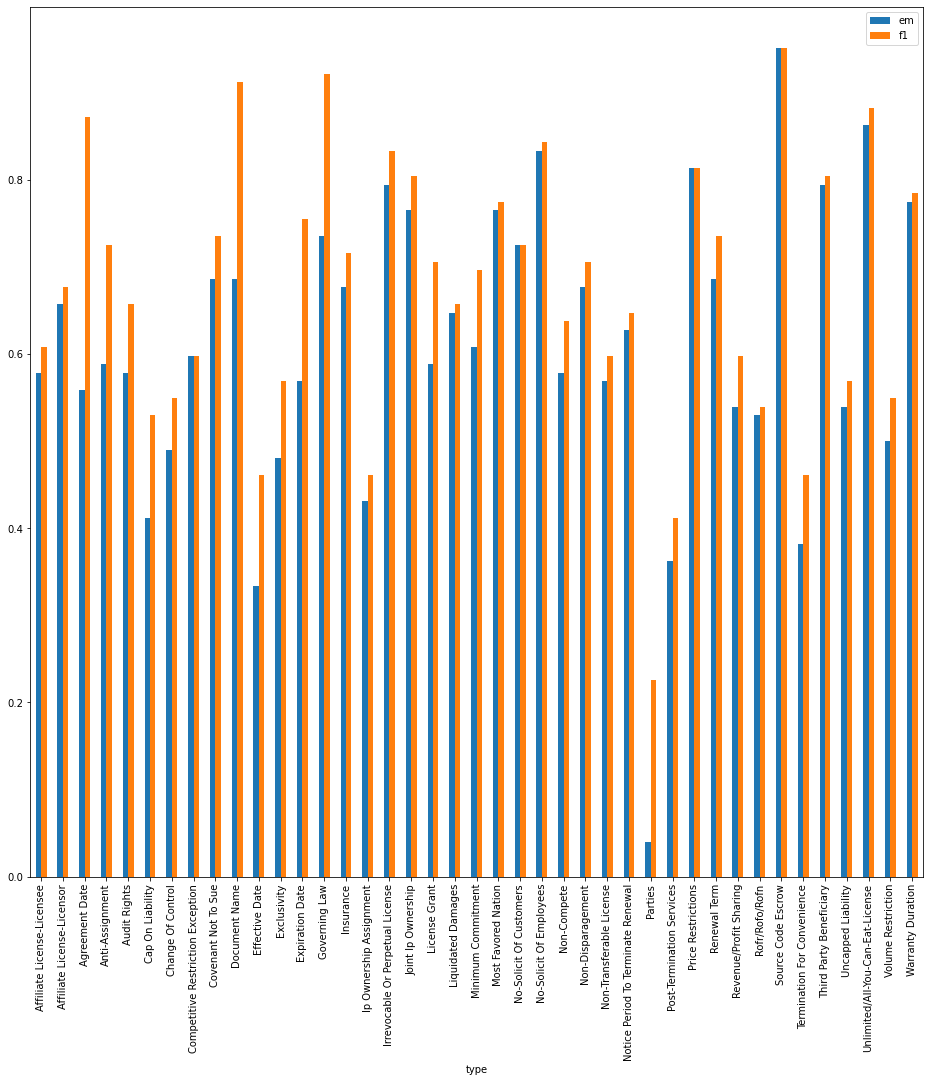

In [7]:
import matplotlib.pyplot as plt
agg = df.groupby('type').agg(['sum','count'])[['em','jaccard_match']]

df2=(agg['em']['sum']/agg['em']['count']).to_frame().merge((agg['jaccard_match']['sum']/agg['jaccard_match']['count']).to_frame(), left_index=True, right_index=True)

df2.rename(columns={'0_x':"em","0_y":"f1"}).plot(kind='bar', figsize=(16,16))

Disregarding the empty predictions lets see how it performs

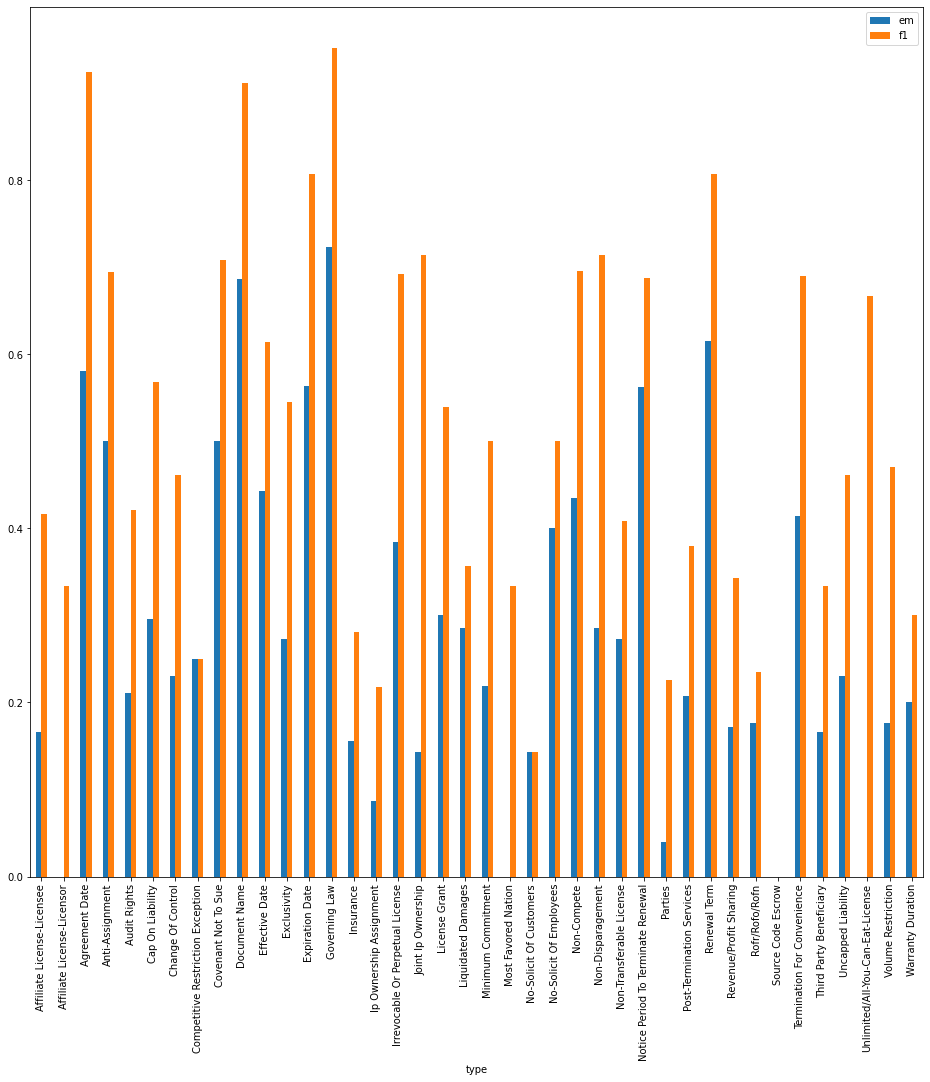

In [8]:
import matplotlib.pyplot as plt
agg = df[df["gt_text"]!=""].groupby('type').agg(['sum','count'])[['em','jaccard_match']]

df2=(agg['em']['sum']/agg['em']['count']).to_frame().merge((agg['jaccard_match']['sum']/agg['jaccard_match']['count']).to_frame(), left_index=True, right_index=True)

df2.rename(columns={'0_x':"em","0_y":"f1"}).plot(kind='bar', figsize=(16,16))

In [ ]:
import matplotlib.pyplot as plt
agg = df[df["gt_text"]!=""].groupby('type').agg(['sum','count'])[['em','jaccard_match']]

df2=(agg['em']['sum']/agg['em']['count']).to_frame().merge((agg['jaccard_match']['sum']/agg['jaccard_match']['count']).to_frame(), left_index=True, right_index=True)

df2.rename(columns={'0_x':"em","0_y":"f1"}).plot(kind='bar', figsize=(16,16))

Where is it we don't predict correctly?

In [10]:
df[(df['jaccard_match']==False) & (df['gt_text']!="")]

,id,type,len,gt,text,probability,start_logit,end_logit,token_doc_start,token_doc_end,gt_text,em,jaccard,jaccard_match
1,LohaCompanyltd_20191209_F-1_EX-10.16_11917878_...,Parties,11475,"[The seller:, The buyer/End-User: Shenzhen LOH...","Shenzhen LOHAS Supply Chain Management Co., Ltd.",0.940892,4.971781,5.013022,9,15,The seller:,False,0.000000,False
37,LohaCompanyltd_20191209_F-1_EX-10.16_11917878_...,Warranty Duration,11475,[Within 7 days after the arrival of the goods ...,In case the accident lasts for more than 10 we...,0.973943,7.321464,7.033958,1414,1433,Within 7 days after the arrival of the goods a...,False,0.118421,False
42,CENTRACKINTERNATIONALINC_10_29_1999-EX-10.3-WE...,Parties,15176,"[Centrack International, I-ON INTERACTIVE, INC...","i-on interactive,",0.445920,7.904738,7.476480,49,50,Centrack International,False,0.000000,False
46,CENTRACKINTERNATIONALINC_10_29_1999-EX-10.3-WE...,Renewal Term,15176,"[Agreement, which notice must be given not les...",This Agreement shall automatically be renewed ...,0.394957,8.768142,7.793366,1571,1604,"Agreement, which notice must be given not less...",False,0.166667,False
47,CENTRACKINTERNATIONALINC_10_29_1999-EX-10.3-WE...,Notice Period To Terminate Renewal,15176,"[Agreement, which notice must be given not les...",This Agreement shall automatically be renewed ...,0.423688,9.199012,8.246860,1571,1604,"Agreement, which notice must be given not less...",False,0.166667,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4128,XinhuaSportsEntertainmentLtd_20070221_F-1_EX-9...,Affiliate License-Licensee,19128,"[media now or hereafter known., (a) store or ...",CEIS hereby grants XFN and its Affiliates a no...,0.384357,7.303731,6.634188,677,774,media now or hereafter known.,False,0.072464,False
4129,XinhuaSportsEntertainmentLtd_20070221_F-1_EX-9...,Unlimited/All-You-Can-Eat-License,19128,"[media now or hereafter known., (a) store or ...",,0.999748,4.715236,4.482395,-1,-1,media now or hereafter known.,False,0.000000,False
4144,MERITLIFEINSURANCECO_06_19_2020-EX-10.(XIV)-MA...,Effective Date,22090,[9/24/2018],The term of this Agreement shall begin on the ...,0.655517,9.682719,9.383440,883,906,9/24/2018,False,0.000000,False
4145,MERITLIFEINSURANCECO_06_19_2020-EX-10.(XIV)-MA...,Expiration Date,22090,[At any time that there is no uncompleted Stat...,The term of this Agreement shall begin on the ...,0.999878,9.542731,9.356908,883,906,At any time that there is no uncompleted State...,False,0.159091,False


### Analysis of performance related to the amount of data present

### Attention weights

In [ ]:
!pip install bertviz

Load in the models and try some examples

In [7]:
from bertviz import head_view, model_view
from transformers import AutoModel, AutoTokenizer

model_version = 'Rakib/roberta-base-on-cuad'
model = AutoModel.from_pretrained(model_version, output_attentions=True)
tokenizer = AutoTokenizer.from_pretrained(model_version)
sentence_a = "EXHIBIT 10.6 DISTRIBUTOR AGREEMENT THIS DISTRIBUTOR AGREEMENT is made by and between Electric City Corp., a Delaware corporation ('Company') and Electric City of Illinois LLC ('Distributor') this 7th day of September, 1999. RECITALS A."
sentence_b = 'Highlight the parts (if any) of this contract related to "Document Name" that should be reviewed by a lawyer. Details: The name of the contract'
inputs = tokenizer.encode_plus(sentence_a, sentence_b, return_tensors='pt')
input_ids = inputs['input_ids']
attention = model(input_ids)[-1]
sentence_b_start = input_ids[0].tolist().index(2)+1
input_id_list = input_ids[0].tolist() # Batch index 0
tokens = tokenizer.convert_ids_to_tokens(input_id_list) 

Some weights of the model checkpoint at Rakib/roberta-base-on-cuad were not used when initializing RobertaModel: ['qa_outputs.weight', 'qa_outputs.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at Rakib/roberta-base-on-cuad and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# Head View
<b>The head view visualizes attention in one or more heads from a single Transformer layer.</b> Each line shows the attention from one token (left) to another (right). Line weight reflects the attention value (ranges from 0 to 1), while line color identifies the attention head. When multiple heads are selected (indicated by the colored tiles at the top), the corresponding  visualizations are overlaid onto one another.  For a more detailed explanation of attention in Transformer models, please refer to the [blog](https://towardsdatascience.com/deconstructing-bert-part-2-visualizing-the-inner-workings-of-attention-60a16d86b5c1).

## Usage
👉 **Hover** over any **token** on the left/right side of the visualization to filter attention from/to that token. <br/>
👉 **Double-click** on any of the **colored tiles** at the top to filter to the corresponding attention head.<br/>
👉 **Single-click** on any of the **colored tiles** to toggle selection of the corresponding attention head. <br/>
👉 **Click** on the **Layer** drop-down to change the model layer (zero-indexed).


In [ ]:
head_view(attention, tokens, sentence_b_start)

# Model View
<b>The model view provides a birds-eye view of attention throughout the entire model</b>. Each cell shows the attention weights for a particular head, indexed by layer (row) and head (column).  The lines in each cell represent the attention from one token (left) to another (right), with line weight proportional to the attention value (ranges from 0 to 1).  For a more detailed explanation, please refer to the [blog](https://towardsdatascience.com/deconstructing-bert-part-2-visualizing-the-inner-workings-of-attention-60a16d86b5c1).

## Usage
👉 **Click** on any **cell** for a detailed view of attention for the associated attention head (or to unselect that cell). <br/>
👉 Then **hover** over any **token** on the left side of detail view to filter the attention from that token.

In [ ]:
model_view(attention, tokens, sentence_b_start)